# Hand Gesture Recognition 

## Import packages

In [0]:
# Here we import everything we need for the project
# It is always recomended to put them in the first cell
from os import listdir
from os import path

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from sklearn.preprocessing import LabelEncoder # for one hot encoding
from keras.models import load_model # to load the saved model 
import json # to load the json file
from PIL import Image # Image manipulations
%matplotlib inline

# To open the drive
from google.colab import drive


# Import of keras model and hidden layers for our convolutional network
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten

# Sklearn
from sklearn.model_selection import train_test_split # Helps with organizing data for training
from sklearn.metrics import confusion_matrix # Helps present results as a confusion-matrix

print(tf.__version__)

2.2.0


Using TensorFlow backend.


## Clone the git model repos 

In [0]:
!git clone https://github.com/Nesrin48/HandGestureRecognition.git

Cloning into 'HandGestureRecognition'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 2608 (delta 38), reused 72 (delta 32), pack-reused 2530
Receiving objects: 100% (2608/2608), 254.21 MiB | 14.79 MiB/s, done.
Resolving deltas: 100% (42/42), done.


In [0]:
# drive.mount('/content/gdrive')

In [0]:
# !ls "/content/gdrive/My Drive/HandGesture"
# to be done first time only to unzip the file
# !unzip "/content/gdrive/My Drive/HandGesture/hand_gesture.zip" -d "/content/gdrive/My Drive/HandGesture/hand_gesture"

## Global Parameters

In [0]:
## Set all the parameter of the model here 
# image_dir = '/content/gdrive/My Drive/HandGesture/hand_gesture/hand_gesture/'
image_dir = 'HandGestureRecognition/handgesture_dataset/'
num_classes = 36

## Plot an image

In [0]:
# This function is used more for debugging and showing results later. It plots the image into the notebook
def imshow(image_path):
  # Open the image to show it in the first column of the plot 
  image = Image.open(image_path)  
  # Create the figure 
  fig = plt.figure(figsize=(50,5))
  ax = fig.add_subplot(1, 1, 1) 
  # Plot the image in the first axe with it's category name
  ax.axis('off')
  ax.set_title(image_path)
  ax.imshow(image) 

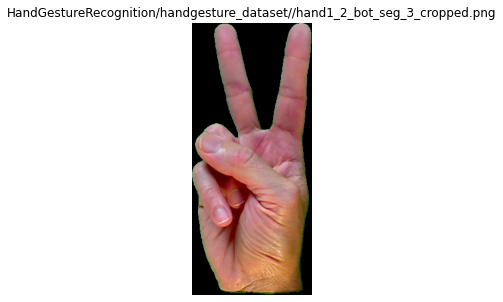

In [0]:
imshow(image_dir + "/hand1_2_bot_seg_3_cropped.png")

## Get Hand gesture labels

In [0]:
def get_hand_gesture_labels(image_dir):
    """
    Creates a dictionary of image labels (results_dic) based upon the filenames 
    of the image files. These image image labels are used to check the accuracy 
    of the labels that are returned by the classifier function, since the 
    filenames of the images contain the true identity of the image in the image.
    Be sure to format the image labels so that they are in all lower case letters
    and with leading and trailing whitespace characters stripped from them.
    (ex. filename = 'hand1_z_dif_seg_4_cropped.png' image label = 'z')
    Parameters:
     image_dir - The (full) path to the folder of images that are to be
                 classified by the classifier function (string)
    Returns:
      results_dic - Dictionary with 'key' as image filename and 'value' as a 
      List. The list contains for following item:
         index 0 = image image label (string)
    """

    # Retrieve the filenames from folder hand_gesture_images/
    in_files = listdir(image_dir)
    # Creates empty dictionary for the results (image labels, etc.)
    results_dic = dict()
    # Processes through each file in the directory, extracting only the words
    # of the file that contain the image image label
    for idx in range(0, len(in_files), 1):
        # Skips file if starts with . (like .DS_Store of Mac OSX) because it 
        # isn't an hand gesture image file
        if in_files[idx][0] != ".":
            if in_files[idx] not in results_dic:
                # Creates temporary label variable to hold pet label name extracted 
                hand_gesture_label = ""         
                # Sets hand_gesture_image variable to a filename after removing the file extension => we can escape this step :D.
                hand_gesture_image = path.splitext(in_files[idx])[0]
                # Sets string to lower case letters
                low_hand_gesture_image = hand_gesture_image.lower()
                # Split the file name by "_" splitter             
                word_list_hand_gesture_image = low_hand_gesture_image.split("_")
                # get hand gesture element which is in the position 2 in the file name 
                hand_gesture_name = word_list_hand_gesture_image[1]
  
                # Strip off starting/trailing whitespace characters 
                hand_gesture_label = hand_gesture_name.strip()
                
                # Add hand_gesture_label as value of the file name key
                results_dic[in_files[idx]] = hand_gesture_label
            else:
                print("** Warning: Duplicate files exist in directory:",in_files[idx])
                
    return results_dic

In [0]:
results_dic = get_hand_gesture_labels(image_dir)
results_dic

{'hand5_u_dif_seg_2_cropped.png': 'u',
 'hand1_b_dif_seg_5_cropped.png': 'b',
 'hand5_j_bot_seg_3_cropped.png': 'j',
 'hand2_c_dif_seg_3_cropped.png': 'c',
 'hand5_0_bot_seg_1_cropped.png': '0',
 'hand5_o_dif_seg_4_cropped.png': 'o',
 'hand1_w_right_seg_4_cropped.png': 'w',
 'hand4_n_bot_seg_5_cropped.png': 'n',
 'hand1_k_bot_seg_4_cropped.png': 'k',
 'hand1_5_left_seg_1_cropped.png': '5',
 'hand1_y_right_seg_2_cropped.png': 'y',
 'hand1_n_dif_seg_3_cropped.png': 'n',
 'hand2_1_bot_seg_1_cropped.png': '1',
 'hand1_e_bot_seg_5_cropped.png': 'e',
 'hand5_x_bot_seg_4_cropped.png': 'x',
 'hand5_f_dif_seg_5_cropped.png': 'f',
 'hand4_f_bot_seg_3_cropped.png': 'f',
 'hand1_3_right_seg_1_cropped.png': '3',
 'hand3_s_dif_seg_2_cropped.png': 's',
 'hand1_i_left_seg_3_cropped.png': 'i',
 'hand2_2_left_seg_1_cropped.png': '2',
 'hand1_e_right_seg_4_cropped.png': 'e',
 'hand2_w_dif_seg_5_cropped.png': 'w',
 'hand1_g_dif_seg_3_cropped.png': 'g',
 'hand3_j_dif_seg_2_cropped.png': 'j',
 'hand1_8_righ

## Load the dataset

In [0]:
def dataset(image_dir):
  X = [] # Image data
  Y = [] # Labels

  # Loops through imagepaths to load images and labels into arrays
  for key in results_dic:
    img = cv2.imread(image_dir + '/'+ key) # Reads image and returns np.array
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the corret colorspace (GRAY)
    img = cv2.resize(img, (320, 120)) # Reduce image size so training can be faster
    X.append(img)
    
    #Get the lable
    label = results_dic[key]
    # Append the lables 
    Y.append(label)

  # Turn X and y into np.array to speed up train_test_split
  X = np.array(X, dtype="uint8")
  Y = np.array(Y)
  print("len(image_dir)",len(image_dir))
  print("len(image_dir)",len(results_dic))
  print("Shape of X ", X.shape)
  print("Shape of Y ", Y.shape)
  X = X.reshape(len(results_dic), 120, 320, 1) # Needed to reshape so CNN knows it's different images
  print("Shape of X after reshaping ", X.shape)
  return X,Y

In [0]:
X,Y = dataset(image_dir)
print("Images loaded: ", len(X))
print("Labels loaded: ", len(Y))

len(image_dir) 43
len(image_dir) 2515
Shape of X  (2515, 120, 320)
Shape of Y  (2515,)
Shape of X after reshaping  (2515, 120, 320, 1)
Images loaded:  2515
Labels loaded:  2515


## Split the dataset

In [0]:
ts = 0.3 # Percentage of images that we want to use for testing. The rest is used for training.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=ts, random_state=42)
y_train.size

1760

## One hot encoding

In [0]:
def one_hot_encode(data):
  label_encoder = LabelEncoder()
  vec = label_encoder.fit_transform(data)
  return vec

In [0]:
print("y_train[:5]", y_train[:5])
y_train = one_hot_encode(y_train)
y_test = one_hot_encode(y_test)
print("y_train[:5]", y_train[:5])

y_train[:5] ['r' 'e' 'o' 'z' 'q']
y_train[:5] [27 14 24 35 26]


## Build the model

In [0]:
# Construction of model
model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(120, 320, 1))) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu')) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

## Train the model

In [0]:
# Configures the model for training
model.compile(optimizer='adam', # Optimization routine, which tells the computer how to adjust the parameter values to minimize the loss function.
              loss='sparse_categorical_crossentropy', # Loss function, which tells us how bad our predictions are.
              metrics=['accuracy']) # List of metrics to be evaluated by the model during training and testing.

In [0]:
# Trains the model for a given number of epochs (iterations on a dataset) and validates it.
model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=2, validation_data=(X_test, y_test))

Train on 1760 samples, validate on 755 samples
Epoch 1/5
 - 11s - loss: 7.5855 - accuracy: 0.3767 - val_loss: 0.6498 - val_accuracy: 0.8066
Epoch 2/5
 - 2s - loss: 0.3308 - accuracy: 0.9080 - val_loss: 0.2595 - val_accuracy: 0.9232
Epoch 3/5
 - 2s - loss: 0.0647 - accuracy: 0.9807 - val_loss: 0.2448 - val_accuracy: 0.9311
Epoch 4/5
 - 2s - loss: 0.0499 - accuracy: 0.9852 - val_loss: 0.2564 - val_accuracy: 0.9364
Epoch 5/5
 - 2s - loss: 0.0229 - accuracy: 0.9915 - val_loss: 0.2388 - val_accuracy: 0.9444


In [0]:
# Save entire model to a HDF5 file
model.save('handrecognition_model.h5')

## Test the Model 

In [0]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy: {:2.2f}%'.format(test_acc*100))

755/755 [==============================] - 1s 747us/step
Test accuracy: 94.44%


In [0]:
predictions = model.predict(X_test) # Make predictions towards the test set
np.argmax(predictions[0]), y_test[0] # If same, got it right

(0, 0)

In [0]:
model = load_model('handrecognition_model.h5')
y_pred = model.predict_classes(X_test)
import sklearn
acc = sklearn.metrics.accuracy_score(np.array(y_pred), np.array(y_test))
print(acc)

0.9443708609271523


## Label mapping

In [0]:
def cat_to_name():
    with open('cat_to_name.json', 'r') as f:
        cat_to_name = json.load(f)
        return cat_to_name

cat_to_name = cat_to_name()   

## Image Preprocessing

In [0]:
def process_image(image_path):
  X = [] # Image data
  img = cv2.imread(image_path) # Reads image and returns np.array
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the corret colorspace (GRAY)
  img = cv2.resize(img, (320, 120)) # Reduce image size so training can be faster
  X.append(img)
  # Turn X into np.array to speed up train_test_split
  X = np.array(X, dtype="uint8")
  print("Shape of X ", X.shape)
  X = X.reshape(len(X), 120, 320, 1) # Needed to reshape so CNN knows it's different images
  print("Shape of X after reshaping ", X.shape)
  return X

## Class Prediction

In [0]:
def predict(image_path, model, cat_to_name,topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    X = process_image(image_path)
    # Get the topk prob using model.predict_proba which return top probablilties 
    # for all calsses in descendent order
    top_p = model.predict_proba(X[:1])[0]
    top_p = [top_p[i] for i in np.argsort(top_p)[-topk:]] # Here we get the topk probas but in assedent order
    top_p = top_p[::-1] # revers the order to get the bigest value to the smallest one in the list of top probs 
    # Get the topk classes 
    top_c = model.predict(X[:1]) 
    top_c = np.argsort(top_c)[:,-topk:][0]
    top_c = top_c[::-1] # reverse elment to get the descenedent order 

    # Extract the classes names from classes indices
    top_classes = [
        cat_to_name[str(category)] for category in top_c
        ]
    return top_p, top_classes

## Sanity Checking

In [0]:
def display_prediction(image_path,model,cat_to_name, topk=5):
    # Open the image to show it in the first column of the plot 
    image = Image.open(image_path)   
    #predict topk classes 
    top_probs, top_classes = predict(image_path, model, cat_to_name,topk)   
    print("top_probs", top_probs)
    print("top_classes ", top_classes )
    # Get the top class that have the max probat
    top_p = top_probs[np.argmax(top_probs)] # the top class proba
    top_c = top_classes[np.argmax(top_probs)] # top class label    

    # Create the figure 
    fig = plt.figure(figsize=(20,5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)    
    # Plot the image in the first axe with it's category name
    ax1.axis('off')
    ax1.set_title(top_c)
    ax1.imshow(image) 
    # Create the second plot 
    #Set the lables of y-awes of the second plot 
    labels = []
    for classe in top_classes:
        labels.append(classe)
    y_pos = np.arange(topk)
    
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(labels)
    ax2.invert_yaxis()  # probabilities read top-to-bottom
    ax2.barh(y_pos, top_probs, xerr=0, align='center')

    plt.show() # show the plot

Shape of X  (1, 120, 320)
Shape of X after reshaping  (1, 120, 320, 1)
top_probs [0.9999944, 5.174918e-06, 3.664176e-07, 8.967844e-08, 5.9762996e-08]
top_classes  ['2', '8', 'K', 'U', 'V']


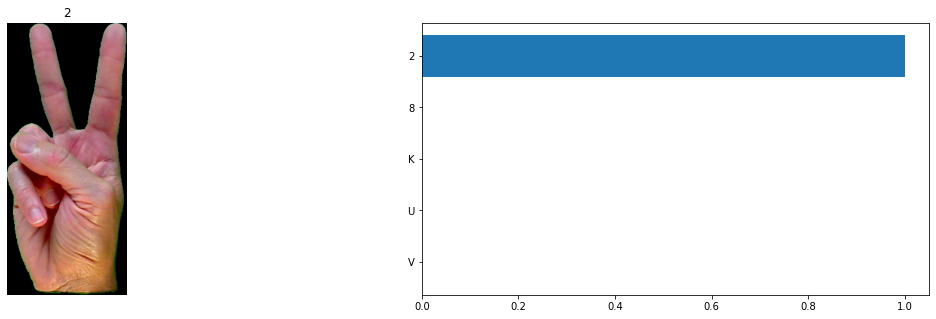

In [0]:
ex_image = image_dir + "/hand1_2_bot_seg_3_cropped.png"
display_prediction(ex_image,model,cat_to_name, topk=5)

In [0]:
arr = [5, 8, 2, 1, 0, 20 , 3]
top_arr = [arr[i] for i in np.argsort(arr)[-3:]]
print("top_arr", top_arr[::-1])

top_arr [20, 8, 5]


# Command Line Application 

In [1]:
!git clone https://github.com/DinaTaklit/HandGestureRecognition.git

Cloning into 'HandGestureRecognition'...
remote: Enumerating objects: 123, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 2653 (delta 66), reused 104 (delta 47), pack-reused 2530
Receiving objects: 100% (2653/2653), 254.29 MiB | 37.72 MiB/s, done.
Resolving deltas: 100% (70/70), done.


## Train the Model

In [2]:
!python HandGestureRecognition/train.py HandGestureRecognition/handgesture_dataset/ --save_dir checkpoints --epochs 5

Using TensorFlow backend.
2020-06-01 07:57:48.619378: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1

############### Train ####################

len(image_dir) 43
len(image_dir) 2515
Shape of X  (2515, 120, 320)
Shape of Y  (2515,)
Shape of X after reshaping  (2515, 120, 320, 1)
2020-06-01 07:57:59.353683: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-06-01 07:57:59.402133: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-06-01 07:57:59.402950: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2020-06-01

## Predict an Input

In [3]:
!python HandGestureRecognition/predict.py  HandGestureRecognition/handgesture_dataset/hand1_2_bot_seg_3_cropped.png checkpoints --category_names HandGestureRecognition/cat_to_name.json --top_k 5

Using TensorFlow backend.
2020-06-01 07:58:46.541299: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1

############### Predict ####################

2020-06-01 07:58:48.885379: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-06-01 07:58:48.906737: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-06-01 07:58:48.907548: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2020-06-01 07:58:48.907602: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10